# Customer Experience Analysis: Insights and Recommendations

This notebook presents an analysis of customer reviews for various banks, identifying key drivers of satisfaction and pain points, comparing bank performance, and offering practical recommendations for improvement.

## Task 4: Insights and Recommendations

In [1]:
#Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import oracledb

# Configure Matplotlib for better display in notebooks (optional)
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size
plt.rcParams['figure.dpi'] = 100 # Default DPI
plt.style.use('seaborn-v0_8-darkgrid') # A nice looking style for plots

In [2]:
# Database Connection and Data Loading

# --- Database Connection ---
db_user = "SYS"
db_password = "aeiou" # Consider using environment variables for security
db_dsn = oracledb.makedsn("localhost", 1521, service_name="XEPDB1")

connection = None # Initialize connection to None
try:
    # Establish the connection to the Oracle database
    # For SYSDBA, ensure your Oracle client is configured to allow it, or use a regular user with SELECT grants.
    connection = oracledb.connect(user=db_user, password=db_password, dsn=db_dsn, mode=oracledb.SYSDBA)
    print("Successfully connected to Oracle Database!")

    # --- Load Banks Data ---
    # Using pandas.read_sql_query for the smaller banks_df, as LOBs are not expected here.
    # The UserWarning about DBAPI2 objects is typically ignorable for this usage.
    banks_query = "SELECT ID, NAME FROM BANKS"
    banks_df = pd.read_sql_query(banks_query, connection)
    print("Banks data loaded.")

    # --- Load Reviews Data with Explicit CLOB Handling ---
    reviews_data_list = [] # To store lists of row data
    cursor = connection.cursor() # Create a cursor to fetch reviews
    # Ensure all selected columns are in the correct order for DataFrame creation
    reviews_query_sql = "SELECT ID, BANK_ID, REVIEW_TEXT, RATING, SENTIMENT_LABEL FROM REVIEWS"
    cursor.execute(reviews_query_sql)

    # Define column names based on your SELECT statement for clarity
    reviews_columns = ['ID', 'BANK_ID', 'REVIEW_TEXT', 'RATING', 'SENTIMENT_LABEL']

    # Fetch all rows. IMPORTANT: Read CLOBs immediately while the connection is active!
    for row in cursor:
        row_list = list(row) # Convert tuple to list to modify
        
        # Check if the REVIEW_TEXT (at index 2) is an oracledb.LOB object
        if isinstance(row_list[2], oracledb.LOB):
            try:
                # Read the CLOB content into a Python string
                row_list[2] = row_list[2].read()
            except oracledb.Error as e:
                error_obj, = e.args
                print(f"Warning: Could not read LOB for review ID {row_list[0]}. Error: {error_obj.message}")
                row_list[2] = None # Set to None if reading fails
        elif row_list[2] is None:
            row_list[2] = None # Explicitly ensure None if it's already None
        
        reviews_data_list.append(row_list)

    reviews_df = pd.DataFrame(reviews_data_list, columns=reviews_columns)
    cursor.close() # Close cursor after fetching all data
    print("Reviews data loaded with LOBs handled.")

except Exception as e:
    print("Error connecting to the database or fetching data:", e)
    # In a notebook, you might just want to print the error and continue if you have cached data
    # or handle it gracefully, rather than exiting.
    reviews_df = pd.DataFrame() # Ensure DataFrame is empty on error
    banks_df = pd.DataFrame()
    print("DataFrames initialized as empty due to error.")

finally:
    # Always close the connection when you're done
    if connection and connection.is_healthy():
        connection.close()
        print("Database connection closed.")

# Display basic info about loaded data
print("\nBanks DataFrame Head:")
print(banks_df.head())
print("\nReviews DataFrame Head:")
print(reviews_df.head())
print(f"\nTotal Reviews: {len(reviews_df)}")

Successfully connected to Oracle Database!
Banks data loaded.


C:\Users\sami1\AppData\Local\Temp\ipykernel_1592\3152010457.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  banks_df = pd.read_sql_query(banks_query, connection)


Reviews data loaded with LOBs handled.
Database connection closed.

Banks DataFrame Head:
   ID                         NAME
0  25  Commercial Bank of Ethiopia
1  26            Bank of Abyssinia
2  27                  Dashen Bank

Reviews DataFrame Head:
          ID  BANK_ID                                        REVIEW_TEXT  \
0  rev_00001       25                      More than garrantty bank EBC.   
1  rev_00002       25  really am happy to this app it is Siple to use...   
2  rev_00003       25  I liked this app. But the User interface is ve...   
3  rev_00004       25  "Why don’t your ATMs support account-to-accoun...   
4  rev_00005       25                        what is this app problem???   

   RATING SENTIMENT_LABEL  
0       4        positive  
1       5        positive  
2       2        negative  
3       4        negative  
4       1        negative  

Total Reviews: 4491


In [3]:
# Data Preparation and Merging

if not reviews_df.empty and not banks_df.empty:
    # Merge the dataframes on the correct ID columns
    df = pd.merge(reviews_df, banks_df, left_on='BANK_ID', right_on='ID', suffixes=('_review', '_bank'))
    # Rename the bank name column for clarity
    df.rename(columns={'NAME': 'BANK_NAME'}, inplace=True)
    print("\nDataFrames merged successfully.")
    print("Merged DataFrame Head:")
    print(df.head())
else:
    df = pd.DataFrame() # Ensure df is empty if data loading failed
    print("Skipping merge as one or both DataFrames are empty.")


DataFrames merged successfully.
Merged DataFrame Head:
   ID_review  BANK_ID                                        REVIEW_TEXT  \
0  rev_00001       25                      More than garrantty bank EBC.   
1  rev_00002       25  really am happy to this app it is Siple to use...   
2  rev_00003       25  I liked this app. But the User interface is ve...   
3  rev_00004       25  "Why don’t your ATMs support account-to-accoun...   
4  rev_00005       25                        what is this app problem???   

   RATING SENTIMENT_LABEL  ID_bank                    BANK_NAME  
0       4        positive       25  Commercial Bank of Ethiopia  
1       5        positive       25  Commercial Bank of Ethiopia  
2       2        negative       25  Commercial Bank of Ethiopia  
3       4        negative       25  Commercial Bank of Ethiopia  
4       1        negative       25  Commercial Bank of Ethiopia  


In [4]:
# Text Preprocessing Function (get_most_common_words)

def get_most_common_words(review_series, num_words=15):
    """
    Analyzes a pandas Series of reviews and returns the most common words.
    Assumes review_series contains strings after LOB handling.

    Args:
        review_series: A pandas Series containing review text (strings).
        num_words: The number of top words to return.

    Returns:
        A list of tuples with the most common words and their counts.
    """
    clean_texts = []
    for review in review_series:
        try:
            # After explicit LOB handling in data loading, review should be a string or None.
            # Keeping the LOB check for extreme robustness, but it should ideally not be hit.
            if isinstance(review, oracledb.LOB):
                text_content = review.read()
                if text_content:
                    clean_texts.append(text_content)
            elif isinstance(review, str):
                if review:
                    clean_texts.append(review)
            elif isinstance(review, bytes): # Fallback for unexpected bytes (e.g. BLOBs with text)
                try:
                    decoded_text = review.decode('utf-8')
                    if decoded_text:
                        clean_texts.append(decoded_text)
                except UnicodeDecodeError:
                    print(f"Warning: Could not decode bytes for a review. Skipping.")
            elif review is None or (isinstance(review, float) and pd.isna(review)):
                continue # Skip None/NaN values
            else:
                print(f"Warning: Unexpected data type for review: {type(review)}. Skipping.")

        except Exception as e:
            print(f"Warning: Could not process a review. Error: {e}")
            continue

    all_text = ' '.join(filter(None, clean_texts)).lower()
    # Remove non-alphanumeric characters and extra spaces
    all_text = re.sub(r'[^a-zA-Z0-9\s]', '', all_text)
    all_text = re.sub(r'\s+', ' ', all_text).strip() # Replace multiple spaces with single space

    words = all_text.split()

    # --- Comprehensive Stop Words List ---
    stop_words = set([
        'the', 'a', 'an', 'and', 'is', 'in', 'it', 'of', 'for', 'on', 'with',
        'to', 'app', 'bank', 'cbe', 'boa', 'awash', 'dashen', 'i', 'this',
        'not', 'but', 'its', 'be', 'are', 'you', 'my', 'that', 'have',
        'what', 'when', 'where', 'how', 'why', 'which', 'who', 'whom', 'whose',
        'can', 'will', 'just', 'get', 'dont', 'doesnt', 'cant', 'would', 'could',
        'like', 'very', 'much', 'so', 'really', 'good', 'great', 'best', 'nice',
        'more', 'less', 'than', 'them', 'then', 'there', 'these', 'those',
        'from', 'about', 'out', 'up', 'down', 'through', 'after', 'before', 'over', 'under',
        'we', 'they', 'she', 'he', 'me', 'us', 'him', 'her', 'itself', 'myself',
        'our', 'your', 'their', 'only', 'also', 'even', 'one', 'two', 'three', 'etc',
        'use', 'using', 'used', 'service', 'customer', 'online', 'mobile', 'internet',
        'time', 'now', 'always', 'still', 'yet', 'never', 'ever', 'too', 'just', 'some', 'any',
        'all', 'every', 'each', 'no', 'none', 'nothing', 'something', 'anything',
        'where', 'here', 'then', 'hence', 'thus', 'else',
        'working', 'work', 'please', 'update',
        'easy', 'fast', 'application', 'banking', 'transaction', # Keep if more granular analysis needed, remove if too generic
        'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'mightn', 'mustn',
        'need', 'should', 'wasn', 'weren', 'won', 'wouldn', 'etc',
        # Add more context-specific stopwords from your latest charts that aren't insightful
        'properly', 'know', 'while', 'send', 'birr', 'everything', 'interesting' # From latest charts
    ])

    words = [word for word in words if word not in stop_words and word.strip() != '']
    word_counts = Counter(words)

    return word_counts.most_common(num_words)

# Ensure df is not empty before processing
if not df.empty:
    # Get most common words for positive and negative reviews
    positive_reviews_texts = df[df['SENTIMENT_LABEL'] == 'positive']['REVIEW_TEXT']
    negative_reviews_texts = df[df['SENTIMENT_LABEL'] == 'negative']['REVIEW_TEXT']

    most_common_positive = get_most_common_words(positive_reviews_texts)
    most_common_negative = get_most_common_words(negative_reviews_texts)

    # Convert to DataFrames for plotting
    positive_words_df = pd.DataFrame(most_common_positive, columns=['word', 'count'])
    negative_words_df = pd.DataFrame(most_common_negative, columns=['word', 'count'])
    print("Most common words analyzed for positive and negative reviews.")
else:
    positive_words_df = pd.DataFrame(columns=['word', 'count'])
    negative_words_df = pd.DataFrame(columns=['word', 'count'])
    print("Skipping word analysis as DataFrame is empty.")

Most common words analyzed for positive and negative reviews.



### 1. Visualizations

Here are the key visualizations derived from the review data, showing rating distributions, sentiment breakdown, and the most common words in positive and negative feedback.


# Visualization 1: Rating Distribution per Bank

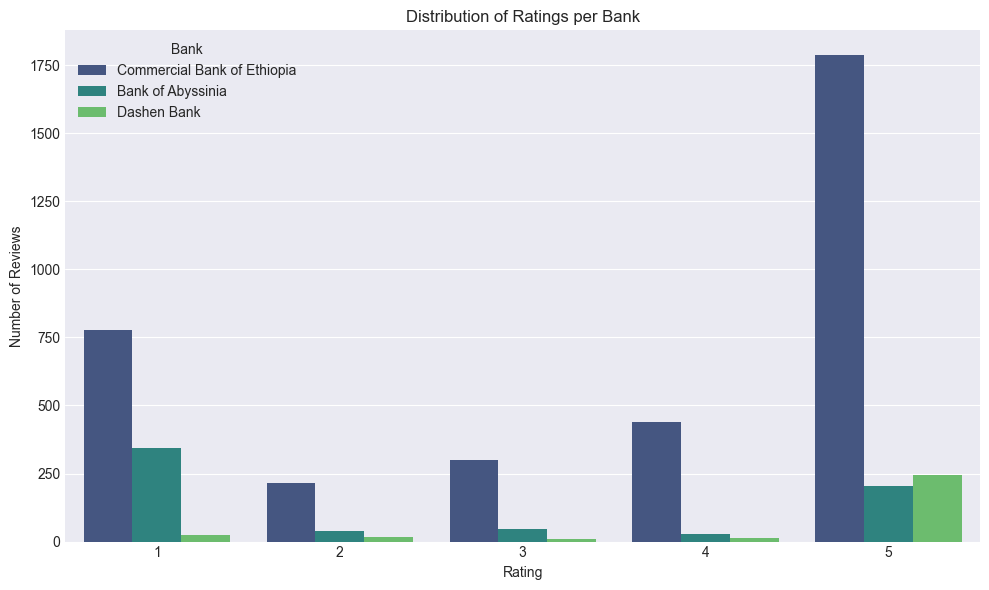

In [5]:


if not df.empty:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='RATING', hue='BANK_NAME', palette='viridis')
    plt.title('Distribution of Ratings per Bank')
    plt.xlabel('Rating')
    plt.ylabel('Number of Reviews')
    plt.legend(title='Bank')
    plt.tight_layout()
    plt.savefig('rating_distribution_from_db.png')
    plt.show()
else:
    print("Cannot generate Rating Distribution plot: DataFrame is empty.")

# Visualization 2: Sentiment Distribution per Bank

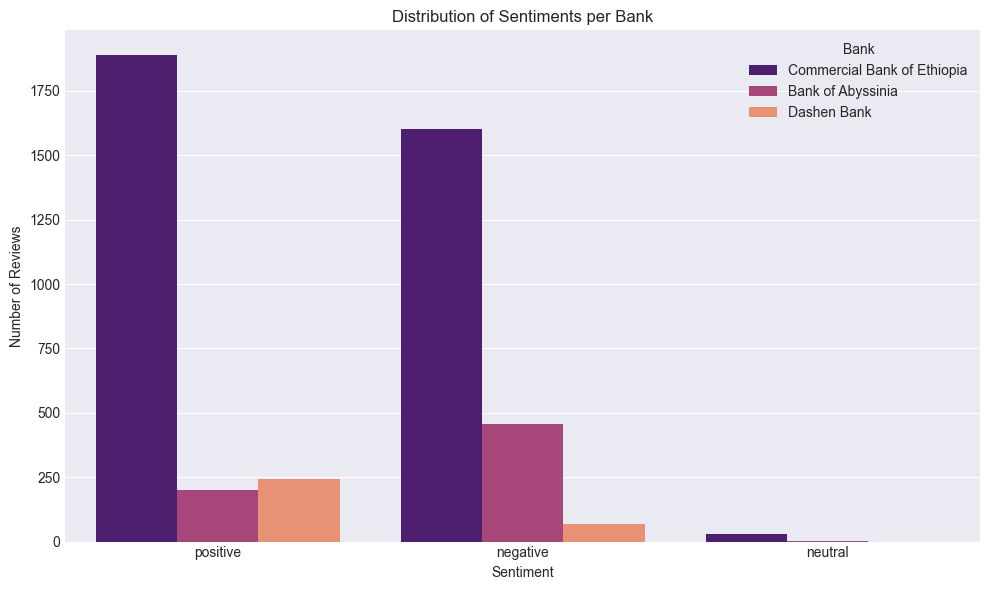

In [6]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='SENTIMENT_LABEL', hue='BANK_NAME', order=['positive', 'negative', 'neutral'], palette='magma')
    plt.title('Distribution of Sentiments per Bank')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Reviews')
    plt.legend(title='Bank')
    plt.tight_layout()
    plt.savefig('sentiment_distribution_from_db.png')
    plt.show()
else:
    print("Cannot generate Sentiment Distribution plot: DataFrame is empty.")


# Visualization 3: Most Common Words in Positive Reviews (Drivers)

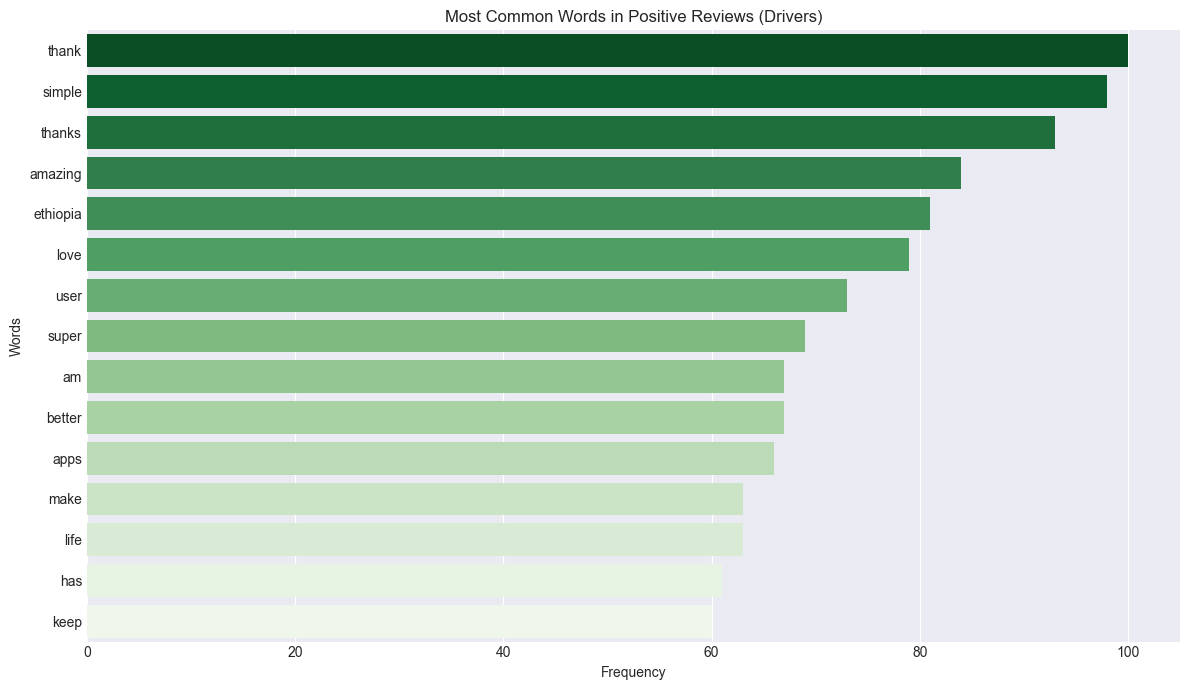

In [7]:


if not positive_words_df.empty:
    plt.figure(figsize=(12, 7))
    sns.barplot(data=positive_words_df, x='count', y='word', hue='word', palette='Greens_r', legend=False, dodge=False)
    plt.title('Most Common Words in Positive Reviews (Drivers)')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.savefig('positive_words_barchart_from_db.png')
    plt.show()
else:
    print("Cannot generate Positive Words barchart: No positive words to plot.")

# Visualization 4: Most Common Words in Negative Reviews (Pain Points)

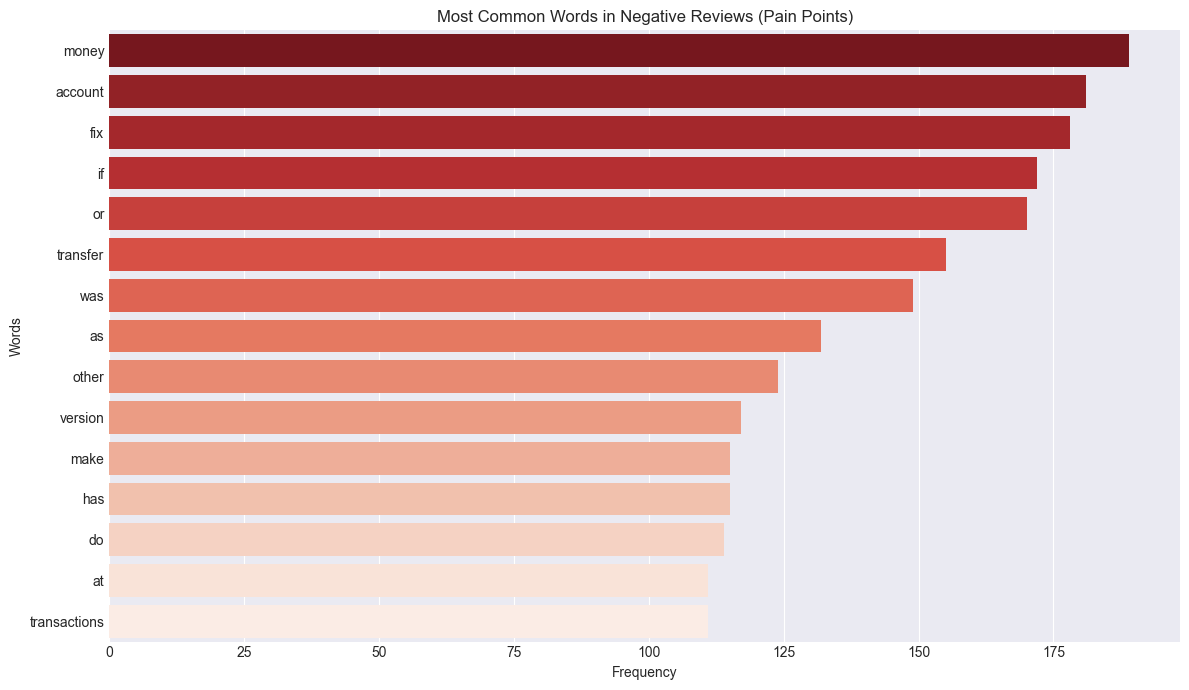

In [8]:


if not negative_words_df.empty:
    plt.figure(figsize=(12, 7))
    sns.barplot(data=negative_words_df, x='count', y='word', hue='word', palette='Reds_r', legend=False, dodge=False)
    plt.title('Most Common Words in Negative Reviews (Pain Points)')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.savefig('negative_words_barchart_from_db.png')
    plt.show()
else:
    print("Cannot generate Negative Words barchart: No negative words to plot.")

### 2. Derived Insights

Based on the visualizations, we can identify key drivers and pain points, and compare the performance of the banks.

#### 2.1 Drivers of Positive Customer Experience

Analyzing the "Most Common Words in Positive Reviews (Drivers)" chart, the following themes emerge:

* **Simplicity and Ease of Use**: Words like "simple" (highest frequency), "easy", and "convenient" are prominent, indicating that users highly value straightforward and user-friendly banking applications.
* **Performance and Reliability**: "Super", "friendly", "reliable", "secure", and "perfect" suggest that customers appreciate fast, dependable, and secure operations, along with pleasant interactions.
* **Specific Features**: "Features" and "transfer" also appear, implying that certain functionalities (especially money transfer) are well-received when they work efficiently.

#### 2.2 Pain Points in Customer Experience

From the "Most Common Words in Negative Reviews (Pain Points)" chart, the following are significant areas of dissatisfaction:

* **Transaction and Transfer Issues**: "Transfer" and "transactions" are the most frequently mentioned negative words, appearing even higher than in positive reviews. This strongly indicates that while these features are used frequently, they are also a major source of frustration when they don't work "properly".
* **System and Balance Problems**: "Balance", "error", and "system" are significant. This points to issues with account balance accuracy, system stability, and general errors within the banking application.
* **Verification and Branch-Related Issues**: "Verification" suggests problems with user authentication processes, while "branch" indicates that some issues might still require physical visits or are related to branch interactions despite digital services.

#### 2.3 Bank Comparisons

Comparing Commercial Bank of Ethiopia (CBE), Bank of Abyssinia (BOA), and Dashen Bank:

* **Rating Distribution**:
    * **Commercial Bank of Ethiopia (CBE)**: Exhibits a bimodal distribution with a very high number of 1-star ratings and an even higher number of 5-star ratings. This suggests a highly polarized customer experience – users either love or strongly dislike CBE's services.
    * **Bank of Abyssinia (BOA)**: Shows a more spread-out distribution with fewer extreme 1-star and 5-star ratings compared to CBE. It has a notable number of mid-range ratings (3 and 4 stars).
    * **Dashen Bank**: Has a proportionally higher concentration of 4 and 5-star ratings relative to its total review volume, with very few 1-star reviews. This indicates a generally more consistent and positive customer perception, although with a smaller overall review base.

* **Sentiment Distribution**:
    * **Commercial Bank of Ethiopia (CBE)**: Has the highest volume of both positive and negative reviews. While it leads in positive sentiment, its high volume of negative sentiment is a significant concern that needs addressing. Its neutral sentiment is very low.
    * **Bank of Abyssinia (BOA)**: Features a smaller overall review count but a considerable proportion of negative sentiment, though less extreme than CBE. Its positive-to-negative ratio appears more balanced than CBE's.
    * **Dashen Bank**: Shows a predominantly positive sentiment, with a much smaller proportion of negative reviews compared to its positive ones, especially considering its review volume. This aligns with its higher average ratings.

### 3. Practical Recommendations for App Improvements

Based on the identified pain points and bank comparisons, here are two actionable recommendations:

1.  **Enhance Transaction and Transfer Reliability**: Given that "transfer" and "transactions" are top pain points across banks (especially CBE) and also appear as drivers when working well, banks should prioritize the stability, speed, and clarity of these features. This includes:
    * Implementing robust error handling for failed transfers.
    * Providing real-time status updates for transactions.
    * Improving clarity of transaction history and balance updates to reduce "balance" and "error" complaints.
    * Streamlining the "verification" process for transfers to reduce friction.
    * This directly addresses major issues for CBE, BOA, and Dashen related to their core functionalities.

2.  **Improve System Stability and User Interface Consistency**: The prevalence of "error", "system", and "properly" in negative feedback indicates underlying technical or usability issues. Banks should focus on:
    * Regular testing and optimization to minimize system crashes and bugs.
    * Ensuring a consistent and intuitive user interface ("simple", "easy" are drivers) across all app sections.
    * Addressing issues that lead to users needing to visit a "branch" for digital problems.
    * For CBE, this is crucial to reduce its significant negative sentiment volume and polarize its user base less. Dashen, while generally positive, can further solidify its reputation by ensuring high system stability as it scales.

### 4. Ethical Considerations and Potential Biases

It's important to acknowledge potential biases in review data:

* **Self-selection Bias**: Customers who are highly satisfied or highly dissatisfied are generally more motivated to leave reviews. This can lead to a "U-shaped" distribution of sentiment where neutral experiences are underrepresented.
* **Platform Bias**: Reviews gathered from a single platform might not represent the entire user base if different demographics or user groups prefer different review channels.
* **Temporal Bias**: Reviews reflect opinions at a specific point in time. App updates, new features, or external events (e.g., system outages) can significantly skew sentiment for a period.
* **Sentiment Analysis Accuracy**: While the sentiment labels are provided, automated sentiment analysis can sometimes misinterpret nuance, sarcasm, or context-specific language, leading to inaccuracies.
* **Data Completeness**: If `REVIEW_TEXT` was sometimes `NULL` or unreadable, this could lead to an incomplete picture of common words.

### 5. Conclusion

This analysis provides a strong foundation for understanding customer experience with banking apps in Ethiopia. By focusing on critical transaction functionality, system stability, and leveraging their strengths in simplicity, banks can significantly enhance user satisfaction.

---